In [58]:
%load_ext autoreload
%autoreload 2
import sys 
if '/Users/ericliu/Desktop/Latent-Dirichilet-Allocation' not in sys.path: 
    sys.path.append('/Users/ericliu/Desktop/Latent-Dirichilet-Allocation')
import torch as tr 
import numpy as np 
from pprint import pprint 
import pandas as pd 
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt 
import copy 

from sklearn.decomposition import LatentDirichletAllocation 
from tuotuo.lda_model import LDASmoothed 
from tuotuo.generator import doc_generator 
from tuotuo.document import Document 
from tuotuo.utils import (
    get_vocab_from_docs, 
    get_np_wct, 
    data_loader,
    text_pipeline, 
    process_documents,
)
from tuotuo.text_pre_processor import (
    remove_accented_chars, 
    remove_special_characters, 
    remove_punctuation,
    remove_extra_whitespace_tabs,
    remove_stopwords,
) 

from tuotuo.cutils import (
    _dirichlet_expectation_1d, 
    _dirichlet_expectation_2d,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Document Generation

In [3]:
gen = doc_generator(
    M = 100,
    L = 20, 
    topic_prior = \
        tr.tensor(
        [1,1,1,1,1], 
        dtype=tr.double
    )
)

In [4]:
gen.alpha

Dirichlet(concentration: torch.Size([5]))

In [5]:
gen.theta.shape

torch.Size([100, 5])

In [6]:
#gen.theta

In [7]:
docs = gen.generate_doc()

In [8]:
print(type(docs)) 

<class 'dict'>


In [9]:
#docs_raw_dict, raw_word_2_idx, raw_idx_2_word = data_loader('ap')

In [10]:
result = process_documents(docs, sample=True)

There are 100 documents in the dataset after processing
On average estimated document length is 10.0 words per document after processing
There are 40 unique vocab in the corpus after processing


In [11]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [12]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [13]:
print(list(result['vocab_doc_count_dict'].keys()))

['immunology', 'electricity', 'form', 'bankrupt', 'contract', 'content', 'injection', 'allergy', 'court', 'Craftsmanship', 'copyright', 'physical', 'recreation', 'contagious', 'Symmetrical', 'exercise', 'appetite', 'FIFA', 'astrophysics', 'quantum', 'decongestant', 'Olympic', 'research', 'scientst', 'attorney', 'game', 'evidence', 'divorce', 'football', 'accuse', 'infection', 'Technique', 'athletics', 'genetics', 'asymmetrical', 'bruise', 'fever', 'picture', 'energy', 'concert']


In [14]:
list1 = list(result['vocab_doc_count_dict'].keys()) 
list2 = list(result['vocab_to_idx'].keys())

for l1, l2 in zip(list1, list2): 
    assert l1 == l2 

In [15]:
result['vocab_doc_count_array'].T

array([[2., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [16]:
doc_vocab_count = np.zeros(
    (
        len(docs), len(result['vocab_to_idx'])
    ),
    dtype = float,
)

for doc_idx, doc in enumerate(result['documents']): 
    for word in doc: 
        vocab_idx = result['vocab_to_idx'][word]
        doc_vocab_count[doc_idx, vocab_idx] += 1 

print(doc_vocab_count.shape)

(100, 40)


In [17]:
doc_vocab_count 

array([[2., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [18]:
(result['vocab_doc_count_array'].T == doc_vocab_count).all()

True

In [19]:
doc_vocab_count

array([[2., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [20]:
doc_vocab_count_df = pd.DataFrame(
    data = doc_vocab_count,
    columns = list(result['vocab_to_idx'].keys())
)
doc_vocab_count_df

,immunology,electricity,form,bankrupt,contract,content,injection,allergy,court,Craftsmanship,...,infection,Technique,athletics,genetics,asymmetrical,bruise,fever,picture,energy,concert
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
96,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
97,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
98,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0


In [21]:
train_docs = Document(docs)


There are 100 documents in the dataset after processing
On average estimated document length is 20.0 words per document after processing
There are 40 unique vocab in the corpus after processing


# Our Model

Topic Dirichlet Prior, α
1

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 40)

Var Inf - Topic Dirichlet prior, Gamma
(100, 5)

Init perplexity = 130.41189958443329
End perplexity = 71.53900578052426
1
1


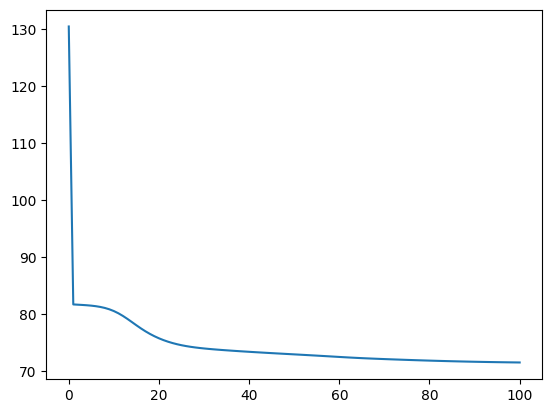

In [159]:
lda = LDASmoothed(
    num_topics = 5, 
    exchangeable_prior = True,
)

perplexes = lda.fit(
    train_doc= train_docs,
    sampling= False,
    update_hyper_parms=False,
    verbose=True,
    return_perplexities=True,
)

plt.plot(perplexes)

print(lda._alpha_)
print(lda._eta_)

Topic Dirichlet Prior, α
1

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 40)

Var Inf - Topic Dirichlet prior, Gamma
(100, 5)

Init perplexity = 130.41189958443329
End perplexity = 70.36409528765788
1.1613896874827732
0.7741824348255312


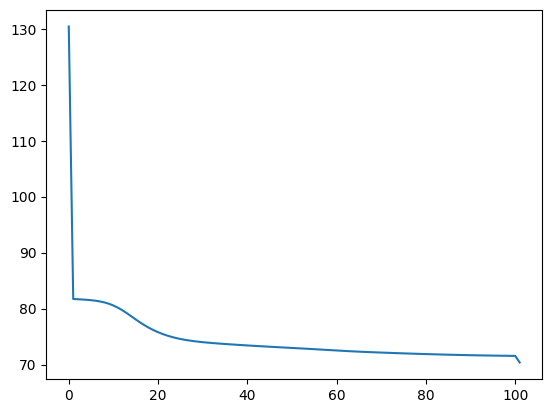

In [160]:
lda = LDASmoothed(
    num_topics = 5, 
    exchangeable_prior = True,
)

perplexes = lda.fit(
    train_doc= train_docs,
    sampling= False,
    update_hyper_parms=True,
    verbose=True,
    return_perplexities=True,
)

plt.plot(perplexes)


print(lda._alpha_)
print(lda._eta_)

In [158]:
print(lda._alpha_)

1.1613896874827732


In [139]:
print(lda._eta_)

1


In [140]:
lda._lambda_[0,30]

21.668797290656705

- As we can see, without update the hyper-parameter $\alpha$ and $\eta$, we extract keywords from topics almost correctly. 

Although we still can see that some are not perfect, i.e. electricity ranked higher than scientist 

In [141]:
lda.get_top_k_words(5)

Topic 0
Top 1 -> decongestant
Top 2 -> injection
Top 3 -> contagious
Top 4 -> allergy
Top 5 -> fever

Topic 1
Top 1 -> electricity
Top 2 -> copyright
Top 3 -> research
Top 4 -> astrophysics
Top 5 -> scientst

Topic 2
Top 1 -> physical
Top 2 -> FIFA
Top 3 -> Olympic
Top 4 -> exercise
Top 5 -> football

Topic 3
Top 1 -> bankrupt
Top 2 -> accuse
Top 3 -> divorce
Top 4 -> attorney
Top 5 -> Technique

Topic 4
Top 1 -> form
Top 2 -> content
Top 3 -> game
Top 4 -> picture
Top 5 -> concert



In [142]:
lda.update_alpha(verbose=True)

-0.1369789272214859
M Step: Iteration 0, Delta Alpha = 0.13697892722148586
Alpha Old:1 -> Alpha New:1.1369789272214859
-0.023849009258976827
M Step: Iteration 1, Delta Alpha = 0.023849009258976928
Alpha Old:1.1369789272214859 -> Alpha New:1.1608279364804628
-0.0005614532381988586
M Step: Iteration 2, Delta Alpha = 0.0005614532381987836
Alpha Old:1.1608279364804628 -> Alpha New:1.1613893897186616
-2.9776402714038696e-07
M Step: Iteration 3, Delta Alpha = 2.9776402721282125e-07
Alpha Old:1.1613893897186616 -> Alpha New:1.1613896874826888
-8.448227041628439e-14
M Step: Iteration 4, Delta Alpha = 8.43769498715119e-14
Alpha Old:1.1613896874826888 -> Alpha New:1.1613896874827732


In [143]:
lda.update_eta(verbose=True,)

0.2989785406231381
M Step: delta eta is 0.2989785406231381
Eta Old 1 -> Eta New 0.7010214593768619
-0.06563225170976486
M Step: delta eta is 0.06563225170976483
Eta Old 0.7010214593768619 -> Eta New 0.7666537110866267
-0.00744859286432742
M Step: delta eta is 0.007448592864327419
Eta Old 0.7666537110866267 -> Eta New 0.7741023039509541
-8.01217923214592e-05
M Step: delta eta is 8.012179232141925e-05
Eta Old 0.7741023039509541 -> Eta New 0.7741824257432756
-9.082255037792021e-09
M Step: delta eta is 9.08225505913407e-09
Eta Old 0.7741824257432756 -> Eta New 0.7741824348255306
-5.137554565125346e-16
M Step: delta eta is 5.551115123125783e-16
Eta Old 0.7741824348255306 -> Eta New 0.7741824348255312


In [144]:
perplexity, expec_logs = lda.approx_perplexity(X=train_docs.doc_vocab_count_array, sampling=False)
print(perplexity)

70.36409528765788


In [97]:
expec_log_theta, expec_log_beta = \
    lda.em_step(
    train_docs.doc_vocab_count_array,
    expec_log_theta= expec_logs[0],
    expec_log_beta= expec_logs[1],
    step= 100,
)

In [98]:
perplexity, expec_logs = lda.approx_perplexity(X=train_docs.doc_vocab_count_array, sampling=False)
print(perplexity)

46.47652231971219


In [99]:
lda.get_top_k_words(5)

Topic 0
Top 1 -> decongestant
Top 2 -> injection
Top 3 -> contagious
Top 4 -> allergy
Top 5 -> fever

Topic 1
Top 1 -> electricity
Top 2 -> copyright
Top 3 -> research
Top 4 -> astrophysics
Top 5 -> scientst

Topic 2
Top 1 -> physical
Top 2 -> FIFA
Top 3 -> Olympic
Top 4 -> exercise
Top 5 -> football

Topic 3
Top 1 -> bankrupt
Top 2 -> accuse
Top 3 -> divorce
Top 4 -> attorney
Top 5 -> Technique

Topic 4
Top 1 -> immunology
Top 2 -> content
Top 3 -> game
Top 4 -> picture
Top 5 -> concert



In [100]:
lda.update_alpha(verbose=True)

M Step: Iteration 0, Delta Alpha = 0.08027160291866675
Alpha Old:1.1613896874827732 -> Alpha New:1.24166129040144
M Step: Iteration 1, Delta Alpha = 0.006551654976064691
Alpha Old:1.24166129040144 -> Alpha New:1.2482129453775046
M Step: Iteration 2, Delta Alpha = 3.80304455365188e-05
Alpha Old:1.2482129453775046 -> Alpha New:1.2482509758230411
M Step: Iteration 3, Delta Alpha = 1.2670720028751248e-09
Alpha Old:1.2482509758230411 -> Alpha New:1.2482509770901131


In [101]:
lda.update_eta(verbose=True,)

M Step: delta eta is 0.050865307722754216
Eta Old 0.7741824348255312 -> Eta New 0.723317127102777
M Step: delta eta is 0.0033907623905818918
Eta Old 0.723317127102777 -> Eta New 0.7267078894933588
M Step: delta eta is 1.7508390844911403e-05
Eta Old 0.7267078894933588 -> Eta New 0.7267253978842038
M Step: delta eta is 4.621935056903226e-10
Eta Old 0.7267253978842038 -> Eta New 0.7267253983463973


# Target model

alpha -> 1
eta -> 1
lambda
(5, 40)
Init perplexity = 100.09491669750783
End perplexity = 51.81904206040911


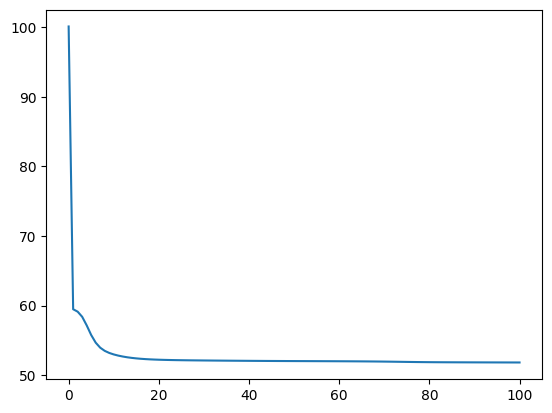

In [84]:
sklearn_lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    doc_topic_prior= 1,
    topic_word_prior= 1,
)
sklearn_lda._init_latent_vars(n_features = lda.V)

print(f"alpha -> {sklearn_lda.doc_topic_prior}")
print(f"eta -> {sklearn_lda.topic_word_prior}")

print('lambda')
print(sklearn_lda.components_.shape)
#assert (sklearn_lda.components_ == lambda_init).all()

perplxities_sklearn = []
init_perplexity = sklearn_lda._perplexity_precomp_distr(
    doc_vocab_count, 
    doc_topic_distr = lda._gamma_,
    sub_sampling=False
)
print(f"Init perplexity = {init_perplexity}")
perplxities_sklearn.append(init_perplexity)

for i in range(100):
    sklearn_lda._em_step(doc_vocab_count, doc_vocab_count.shape[0], True, )
    em_step_perplexity = sklearn_lda.perplexity(doc_vocab_count)
    #print(f"{i+1} EM step perplexity is {em_step_perplexity}")
    perplxities_sklearn.append(em_step_perplexity)
print(f"End perplexity = {perplxities_sklearn[-1]}")
plt.plot(perplxities_sklearn)